In [1]:
%env MIRA_REST_URL=http://34.230.33.149:8771
from mira.sources import biomodels
from mira.metamodel.comparison import *
from mira.metamodel.template_model import *
from mira.metamodel.templates import *
from mira.sources import biomodels

from itertools import combinations
from copy import deepcopy
from tabulate import tabulate

import pandas as pd 

env: MIRA_REST_URL=http://34.230.33.149:8771


In [2]:
COVID_MODEL_LIST = ["BIOMD0000000955", "BIOMD0000000956", "BIOMD0000000957","BIOMD0000000958","BIOMD0000000960","BIOMD0000000962",
                    "BIOMD0000000963", 
                    "BIOMD0000000964", "BIOMD0000000969", "BIOMD0000000970","BIOMD0000000971","BIOMD0000000972",
                    "BIOMD0000000974","BIOMD0000000976", 
                    "BIOMD0000000977", "BIOMD0000000978", "BIOMD0000000979", "BIOMD0000000980", "BIOMD0000000981",
                    "BIOMD0000000982",
                    "BIOMD0000000983",
                    "BIOMD0000000984","BIOMD0000000988","BIOMD0000000991"]

In [3]:
rc = get_dkg_refinement_closure()

tm_covid_grounding_list = []
for covid_model in COVID_MODEL_LIST:
    tm_covid_grounding_list.append(biomodels.get_template_model(covid_model))

model_id_name_mapping = {id:tm.annotations.name.split(' ')[0] for id,tm in enumerate(tm_covid_grounding_list)}

In [4]:
tm_covid_comparison = TemplateModelComparison(tm_covid_grounding_list,refinement_func=rc.is_ontological_child)

Comparing model templates: 22791it [00:00, 96096.12it/s] 
Comparing model concepts: 14196it [00:00, 119257.12it/s]


In [5]:
grounded_scores = tm_covid_comparison.model_comparison.get_similarity_scores()

In [6]:
tm_covid_no_grounding_list = [] 
for tm in tm_covid_grounding_list:
    copied_tm = deepcopy(tm)
    for template in copied_tm.templates:
        for concept in template.get_concepts():
            concept.identifiers = {}
            concept.context = {}
    tm_covid_no_grounding_list.append(copied_tm)

In [7]:
tm_covid_comparison_copy = TemplateModelComparison(tm_covid_no_grounding_list,refinement_func=rc.is_ontological_child)
ungrounded_scores = tm_covid_comparison_copy.model_comparison.get_similarity_scores()

list_of_both = []

for grounded_score,ungrounded_score in zip(grounded_scores,ungrounded_scores):
    list_of_both.append({'Model1':model_id_name_mapping[grounded_score['models'][0]],
                         'Model2':model_id_name_mapping[grounded_score['models'][1]],
                         'sim_dkg':grounded_score['score'],
                        'sim_no_dkg':ungrounded_score['score']})

Comparing model templates: 22791it [00:00, 138074.63it/s]
Comparing model concepts: 14196it [00:00, 246501.10it/s]


In [8]:
after_sim_lower_count = 0
after_sim_higher_count = 0
after_sim_same = 0 
for model_comparison in list_of_both:
    if model_comparison['sim_no_dkg'] < model_comparison['sim_dkg']:
        after_sim_lower_count += 1
    elif model_comparison['sim_no_dkg'] > model_comparison['sim_dkg']:
        after_sim_higher_count += 1
    elif model_comparison['sim_no_dkg'] == model_comparison['sim_dkg']:
        after_sim_same += 1
print(f"Removing groundings led to a decrease in pairwise similarity scores for {after_sim_lower_count} or {round(after_sim_lower_count /len(list_of_both),2)}% of the {len(list_of_both)} pairwise model comparisons.")

Removing groundings led to a decrease in pairwise similarity scores for 231 or 0.84% of the 276 pairwise model comparisons.


In [9]:
print(f"Removing groundings led to an increase in pairwise similarity scores for {after_sim_higher_count} or {round(after_sim_higher_count/len(list_of_both),2)}% of the 276 pairwise model comparisons.")

Removing groundings led to an increase in pairwise similarity scores for 11 or 0.04% of the 276 pairwise model comparisons.


In [10]:
print(f"Removing groundings led to no change in pairwise similarity scores for {after_sim_same} or {round(after_sim_same/len(list_of_both),2)}% of the {len(list_of_both)} pairwise model comparisons.")

Removing groundings led to no change in pairwise similarity scores for 34 or 0.12% of the 276 pairwise model comparisons.


In [11]:
diffs = []
for model_comparison in list_of_both:
    diffs.append(model_comparison['sim_dkg'] - model_comparison['sim_no_dkg'])

In [12]:
import matplotlib.pyplot as plt

(0.5, 1.5)

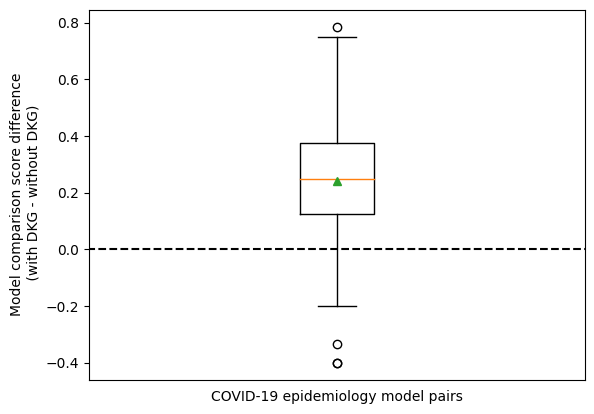

In [29]:
plt.boxplot(diffs, showmeans=True)
plt.ylabel('Model comparison score difference\n (with DKG - without DKG)')
plt.xlabel('COVID-19 epidemiology model pairs')
plt.xticks([])
plt.plot([-1, 2], [0, 0], 'k--')
plt.xlim([0.5, 1.5])

(0.5, 1.5)

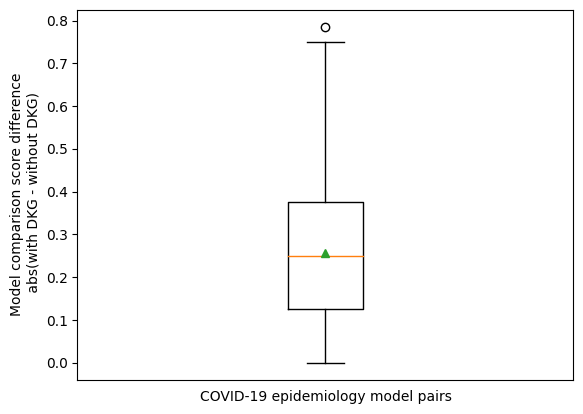

In [32]:
plt.boxplot([abs(d) for d in diffs], showmeans=True)
plt.ylabel('Model comparison score difference\n abs(with DKG - without DKG)')
plt.xlabel('COVID-19 epidemiology model pairs')
plt.xticks([])
plt.xlim([0.5, 1.5])

In [33]:
len(diffs)

276